In [1]:
!pip install pandas tensorflow tensorflow_hub tensorflow_text 

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os 
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub
import pandas as pd

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

# Load and Prepare Dataset

 - Download the raw text files from http://mlg.ucd.ie/datasets/bbc.html and unzip in the same directory as this notebook.

In [3]:
num_classes = 5

class_name_to_idx_map = {
    "business": 0,
    "entertainment": 1,
    "politics": 2,
    "sport": 3,
    "tech": 4
}

class_idx_to_class_map = { idx: name for name, idx in class_name_to_idx_map.items() }


def generateCategoryDF(category, category_label, dataset_path="bbc/"):
    article_filepath_list = []
    article_text_list = []
    for filename in os.listdir(os.path.join(dataset_path,category)):
        filepath = os.path.join(dataset_path,category,filename)
        #print(filepath)
        article_filepath_list.append(filepath)
        with open(filepath, "rb") as f:
            file_text = f.read()
        article_text_list.append(str(file_text).replace("\n", " "))

    df = pd.DataFrame(data={"file": article_filepath_list, "text":article_text_list})
    df["category"] = category
    df["category_label"] = category_label
    
    return df


business_df = generateCategoryDF("business", 0, dataset_path="bbc/")
entertainment_df = generateCategoryDF("entertainment", 1, dataset_path="bbc/")
politics_df = generateCategoryDF("politics", 2, dataset_path="bbc/")
sport_df = generateCategoryDF("sport", 3, dataset_path="bbc/")
tech_df = generateCategoryDF("tech", 4, dataset_path="bbc/")

articles_df = pd.concat([business_df, entertainment_df, politics_df, sport_df, tech_df])
articles_df = articles_df.sample(frac=1).reset_index(drop=True)
articles_df.head()

,file,text,category,category_label
0,bbc/sport/167.txt,b'Robben plays down European return\n\nInjured...,sport,3
1,bbc/entertainment/192.txt,b'Springer criticises Opera musical\n\nTalk sh...,entertainment,1
2,bbc/politics/285.txt,b'Hague \'given up\' his PM ambition\n\nFormer...,politics,2
3,bbc/politics/340.txt,b'Lib Dems unveil women\'s manifesto\n\nThe Li...,politics,2
4,bbc/politics/096.txt,b'Tories \'would cut number of MPs\'\n\nThe Co...,politics,2


## Train / Validation / Test Split

In [4]:
train_df = articles_df.sample(frac=0.05)

val_and_test_df = articles_df.drop(train_df.index)
val_df = val_and_test_df.sample(frac=0.5)
test_df = val_and_test_df.drop(val_df.index)

print(f"len(train_df) = {len(train_df)}")
print(f"len(val_df) = {len(val_df)}")
print(f"len(test_df) = {len(test_df)}")

len(train_df) = 111
len(val_df) = 1057
len(test_df) = 1057


Number of training example per class:

<AxesSubplot:>

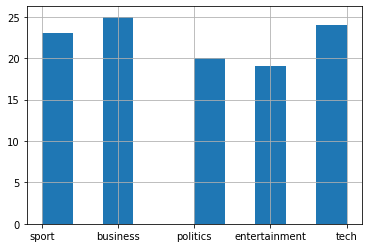

In [5]:
train_df["category"].hist()

# Training a Classification Model



In [6]:
x_train = list(train_df["text"])
y_train = list(train_df["category_label"])

x_val = list(val_df["text"])
y_val = list(val_df["category_label"])

In [7]:
classification_model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3", 
                   input_shape=[], dtype=tf.string, trainable=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

classification_model.compile(optimizer='adam',
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                             metrics=['accuracy'])

classification_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=20, epochs=100)

Epoch 1/100
6/6 [==============================] - 4s 685ms/step - loss: 1.5999 - accuracy: 0.2523 - val_loss: 1.5873 - val_accuracy: 0.2999
Epoch 2/100
6/6 [==============================] - 3s 497ms/step - loss: 1.5765 - accuracy: 0.3243 - val_loss: 1.5700 - val_accuracy: 0.4210
Epoch 3/100
6/6 [==============================] - 3s 497ms/step - loss: 1.5528 - accuracy: 0.4775 - val_loss: 1.5531 - val_accuracy: 0.5402
Epoch 4/100
6/6 [==============================] - 3s 510ms/step - loss: 1.5321 - accuracy: 0.5045 - val_loss: 1.5370 - val_accuracy: 0.6462
Epoch 5/100
6/6 [==============================] - 3s 491ms/step - loss: 1.5156 - accuracy: 0.5946 - val_loss: 1.5207 - val_accuracy: 0.7171
Epoch 6/100
6/6 [==============================] - 3s 496ms/step - loss: 1.4962 - accuracy: 0.6847 - val_loss: 1.5045 - val_accuracy: 0.7578
Epoch 7/100
6/6 [==============================] - 3s 506ms/step - loss: 1.4681 - accuracy: 0.7568 - val_loss: 1.4884 - val_accuracy: 0.7796
Epoch 8/100
6

Epoch 59/100
6/6 [==============================] - 3s 509ms/step - loss: 0.7674 - accuracy: 0.9820 - val_loss: 0.8856 - val_accuracy: 0.9395
Epoch 60/100
6/6 [==============================] - 3s 505ms/step - loss: 0.7463 - accuracy: 0.9910 - val_loss: 0.8778 - val_accuracy: 0.9404
Epoch 61/100
6/6 [==============================] - 3s 498ms/step - loss: 0.7387 - accuracy: 0.9910 - val_loss: 0.8703 - val_accuracy: 0.9385
Epoch 62/100
6/6 [==============================] - 3s 510ms/step - loss: 0.7500 - accuracy: 0.9730 - val_loss: 0.8625 - val_accuracy: 0.9385
Epoch 63/100
6/6 [==============================] - 3s 500ms/step - loss: 0.7357 - accuracy: 0.9730 - val_loss: 0.8552 - val_accuracy: 0.9404
Epoch 64/100
6/6 [==============================] - 3s 489ms/step - loss: 0.7288 - accuracy: 0.9730 - val_loss: 0.8478 - val_accuracy: 0.9404
Epoch 65/100
6/6 [==============================] - 3s 515ms/step - loss: 0.7128 - accuracy: 0.9640 - val_loss: 0.8405 - val_accuracy: 0.9404
Epoch 

# Model Evaluation


In [8]:
x_test = list(test_df["text"])
y_test = list(test_df["category_label"])
loss, accuracy = classification_model.evaluate(x_test, y_test)
print(f"Test set accuracy = {accuracy*100}%")

34/34 [==============================] - 2s 65ms/step - loss: 0.6233 - accuracy: 0.9584
Test set accuracy = 95.83727717399597%


#  Misclassified Examples

In [9]:
y_test_predicted = classification_model.predict_classes(x_test)
y_test_predicted_probabilities = classification_model.predict(x_test)

for idx, correct_news in enumerate(y_test == y_test_predicted):
    if not correct_news:
        #print(idx)
        print(test_df.iloc[idx]["text"][:1000])
        print("\n")
        print(f"\t class label = {class_idx_to_class_map[y_test[idx]]} "
              f"(class probability = {y_test_predicted_probabilities[idx][y_test[idx]]})")
        print(f"\t predicted label = {class_idx_to_class_map[y_test_predicted[idx]]} "
              f"(class probability = {y_test_predicted_probabilities[idx][y_test_predicted[idx]]})")
        print("\n\n -------------------------------------------------------------------- \n\n")

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


b"Bond game fails to shake or stir\n\nFor gaming fans, the word GoldenEye evokes excited memories not only of the James Bond revival flick of 1995, but also the classic shoot-em-up that accompanied it and left N64 owners glued to their consoles for many an hour.\n\nAdopting that hallowed title somewhat backfires on this new game, for it fails to deliver on the promise of its name and struggles to generate the original's massive sense of fun. This however is not a sequel, nor does it relate to the GoldenEye film. You are the eponymous renegade spy, an agent who deserts to the Bond world's extensive ranks of criminal masterminds, after being deemed too brutal for MI6. Your new commander-in-chief is the portly Auric Goldfinger, last seen in 1964, but happily running around bent on world domination. With a determination to justify its name which is even less convincing than that of Tina Turner's similarly-titled theme song, the game literally gives the player a golden eye following an inju

# Multilingual Classification Capabilities

- Applying the classification model to english sentences and corresponding french and spanish translations to demonstrate the multilingual capability.

In [10]:
mulitlingual_texts_list = [
    {
        "english": "The stock market crashed after the announcement",
        "french": "La bourse s'est effondrée après l'annonce",
        "spanish": "El mercado de valores se desplomó tras el anuncio"
    },
    {
        "english": "The new TV show had great ratings",
        "french": "La nouvelle émission de télévision a eu de bonnes notes",
        "spanish": "El nuevo programa de televisión tuvo grandes índices de audiencia."
    },
    {
        "english": "The thrilling soccer match ended in a victory for the home team ",
        "french": "Le match de football passionnant s'est terminé par une victoire pour l'équipe locale",
        "spanish": "El apasionante partido de fútbol acabó con victoria del equipo local"
    },
    {
        "english": "iPhone 12 vs. XR, XS, X: What Apple changed in 2020, from 5G to MagSafe",
        "french": "iPhone 12 vs XR, XS, X: ce qu'Apple a changé en 2020, de la 5G à MagSafe",
        "spanish": "iPhone 12 vs.XR, XS, X: lo que Apple cambió en 2020, de 5G a MagSafe"
    },
    {
        "english": "The polls show that the debate last week did not have a large effect on the voting intentions.",
        "french": "Les sondages montrent que le débat de la semaine dernière n'a pas eu un effet important sur les intentions de vote",
        "spanish": "Las encuestas muestran que el debate de la semana pasada no tuvo un gran efecto en las intenciones de voto"
    }
]

In [11]:
for mulitlingual_texts in mulitlingual_texts_list:
    for language, text in mulitlingual_texts.items():
        print(f"{language}: {text} -> {class_idx_to_class_map[classification_model.predict_classes([text])[0]]}")
    print()

english: The stock market crashed after the announcement -> business
french: La bourse s'est effondrée après l'annonce -> business
spanish: El mercado de valores se desplomó tras el anuncio -> business

english: The new TV show had great ratings -> entertainment
french: La nouvelle émission de télévision a eu de bonnes notes -> entertainment
spanish: El nuevo programa de televisión tuvo grandes índices de audiencia. -> entertainment

english: The thrilling soccer match ended in a victory for the home team  -> sport
french: Le match de football passionnant s'est terminé par une victoire pour l'équipe locale -> sport
spanish: El apasionante partido de fútbol acabó con victoria del equipo local -> sport

english: iPhone 12 vs. XR, XS, X: What Apple changed in 2020, from 5G to MagSafe -> tech
french: iPhone 12 vs XR, XS, X: ce qu'Apple a changé en 2020, de la 5G à MagSafe -> tech
spanish: iPhone 12 vs.XR, XS, X: lo que Apple cambió en 2020, de 5G a MagSafe -> tech

english: The polls show 